<a href="https://colab.research.google.com/github/Mostafaali3/Machine_Learning_Project/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [3]:
!pip install wfdb
!pip install scipy
!pip install antropy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 93.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [80]:
#@title Imports
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import scipy
from scipy.signal import welch, find_peaks
import antropy as ant
import os
import csv

In [114]:
#@title Important Paths
original_dataset_path = '/content/drive/MyDrive/ML Project Dataset/1.0.0'  # path of dataset in your drive
split_dataset_path = '/content/drive/MyDrive/ML Project Dataset/Split Records'  # middle step
final_dataset_path = '/content/drive/MyDrive/ML Project Dataset/Final Dataset'
records_path = f'{original_dataset_path}/WFDB'
labels_csv_path = f'{original_dataset_path}/ECGPCGSpreadsheet.csv'
final_labels_csv = f'{final_dataset_path}/labels.csv'

# Exploratory Data Analysis (EDA)

## Data Exploration

In [115]:
example_record = wfdb.rdrecord(f"{records_path}/ECGPCG0001")
print(dir(example_record))  # all record attributes

TypeError: 'str' object is not callable

In [102]:
def print_record_info(record):
  print(f"Record Name {type(record.record_name)}:", record.record_name)
  print(f"Number of Signals {type(record.n_sig)}:", record.n_sig)
  print(f"Sampling Frequency (Hz) {type(record.fs)}:", record.fs)
  print(f"Signal Names {type(record.sig_name)}:", record.sig_name)
  print(f"Signal Units {type(record.units)}:", record.units)
  print(f"Comments {type(record.comments)}:", record.comments)  # doesn't carry label
  print(f"Signal Length {type(record.sig_len)}:", record.sig_len)
  print(f"Elapsed Time {type(record.get_elapsed_time)}:", record.get_elapsed_time(record.sig_len))  # we can use this to verify duration of signal
  print(f"Signal {type(record.p_signal)}, {record.p_signal.shape}:", record.p_signal)  # carries both signals

print_record_info(example_record)

Record Name <class 'str'>: ECGPCG0001
Number of Signals <class 'int'>: 2
Sampling Frequency (Hz) <class 'int'>: 8000
Signal Names <class 'list'>: ['ECG', 'PCG']
Signal Units <class 'list'>: ['mV', 'mV']
Comments <class 'list'>: ['The simultaneous electrocardiogram and phonocardiogram database']
Signal Length <class 'int'>: 14400000
Elapsed Time <class 'method'>: 0:30:00
Signal <class 'numpy.ndarray'>, (14400000, 2): [[-0.02735159  0.99950676]
 [-0.02831017 -0.00145639]
 [-0.02831017 -0.00196053]
 ...
 [ 0.01757403  0.03711005]
 [ 0.01708409  0.03565366]
 [ 0.01757403  0.03514952]]


## Labels CSV Processing

In [7]:
labels_df = pd.read_csv(labels_csv_path)
labels_df.head()

,Record Name,Subject ID,Record Duration (min),Age (years),Gender,Recording Scenario,Num Channels,ECG Notes,PCG Notes,PCG2 Notes,...,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44
0,ECGPCG0001,S023,30.0,NaN,Male,Exercise: pedaling a stationary bicycle,2.0,Good,Good,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ECGPCG0002,S024,30.0,NaN,Male,Exercise: pedaling a stationary bicycle,2.0,Good; occasional saturation,Good,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ECGPCG0003,S003,0.5,28.0,Male,Rest: sitting on armchair,2.0,Good,Good,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ECGPCG0004,S004,0.5,26.0,Male,Rest: sitting on armchair,5.0,Good,Occasional burst powerline noise,Quantization noise level,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ECGPCG0005,S005,0.5,23.0,Male,Rest: sitting on armchair,5.0,Good,Occasional burst powerline noise,Quantization noise level,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dropping empty rows

In [8]:
print(f"Count of empty rows: {labels_df.isnull().all(axis=1).sum()}")
empty_rows = labels_df[labels_df.isnull().all(axis=1)]
print(empty_rows)

Count of empty rows: 1
   Record Name Subject ID  Record Duration (min)  Age (years) Gender  \
69         NaN        NaN                    NaN          NaN    NaN   

   Recording Scenario  Num Channels ECG Notes PCG Notes PCG2 Notes  ...  \
69                NaN           NaN       NaN       NaN        NaN  ...   

   Unnamed: 35 Unnamed: 36 Unnamed: 37  Unnamed: 38  Unnamed: 39  Unnamed: 40  \
69         NaN         NaN         NaN          NaN          NaN          NaN   

    Unnamed: 41  Unnamed: 42  Unnamed: 43  Unnamed: 44  
69          NaN          NaN          NaN          NaN  

[1 rows x 45 columns]


In [9]:
labels_df.drop(empty_rows.index, inplace=True)
labels_df.reset_index(drop=True, inplace=True)

print(f"Count of empty rows: {labels_df.isnull().all(axis=1).sum()}")

Count of empty rows: 0


### Ignoring empty columns

In [10]:
labels_df.columns

Index(['Record Name', 'Subject ID', 'Record Duration (min)', 'Age (years)',
       'Gender', 'Recording Scenario', 'Num Channels', 'ECG Notes',
       'PCG Notes', 'PCG2 Notes', 'AUX1 Notes', 'AUX2 Notes',
       'Database Housekeeping', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19',
       'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23',
       'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27',
       'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31',
       'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35',
       'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39',
       'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43',
       'Unnamed: 44'],
      dtype='object')

In [11]:
# keep relative columns only
labels_df = labels_df[['Record Name', 'Subject ID', 'Record Duration (min)', 'Age (years)',
       'Gender', 'Recording Scenario', 'Num Channels', 'ECG Notes',
       'PCG Notes', 'PCG2 Notes', 'AUX1 Notes', 'AUX2 Notes',
       'Database Housekeeping']]
labels_df.columns

Index(['Record Name', 'Subject ID', 'Record Duration (min)', 'Age (years)',
       'Gender', 'Recording Scenario', 'Num Channels', 'ECG Notes',
       'PCG Notes', 'PCG2 Notes', 'AUX1 Notes', 'AUX2 Notes',
       'Database Housekeeping'],
      dtype='object')

### Identifying all unique scenarios and durations of experiment

In [12]:
labels_df['Recording Scenario'].unique()

array(['Exercise: pedaling a stationary bicycle',
       'Rest: sitting on armchair', 'Rest: laying on bed',
       'Exercise: slow walk (7 min); fast walk (8 min); sit down and stand up (4 min); slow walk (6 min);rest',
       'Exercise: slow walk (7 min); fast walk (8 min); sit down and stand up (4 min); slow walk (6 min); rest',
       'Exercise: Bruce protocol treadmill stress test',
       'Exercise: walking at constant speed (3.7 km/h) ',
       'Exercise: bicycle stress test'], dtype=object)

In [13]:
# Two identical scenarios have a small typo that makes them appear different
labels_df['Recording Scenario']  = labels_df['Recording Scenario'].replace(
   'Exercise: slow walk (7 min); fast walk (8 min); sit down and stand up (4 min); slow walk (6 min);rest',
   'Exercise: slow walk (7 min); fast walk (8 min); sit down and stand up (4 min); slow walk (6 min); rest'
)

In [14]:
all_recording_scenarios = labels_df['Recording Scenario'].unique()
print(all_recording_scenarios)
print()
print(labels_df['Record Duration (min)'].unique())

['Exercise: pedaling a stationary bicycle' 'Rest: sitting on armchair'
 'Rest: laying on bed'
 'Exercise: slow walk (7 min); fast walk (8 min); sit down and stand up (4 min); slow walk (6 min); rest'
 'Exercise: Bruce protocol treadmill stress test'
 'Exercise: walking at constant speed (3.7 km/h) '
 'Exercise: bicycle stress test']

[30.   0.5]


In [21]:
for i, scenario in enumerate(all_recording_scenarios):
  print(f"Index: {i}, Scenario: {scenario}")
  print(labels_df[labels_df['Recording Scenario'] == scenario]['Record Duration (min)'].unique())
  print()

Index: 0, Scenario: Exercise: pedaling a stationary bicycle
[30.]

Index: 1, Scenario: Rest: sitting on armchair
[ 0.5 30. ]

Index: 2, Scenario: Rest: laying on bed
[30.]

Index: 3, Scenario: Exercise: slow walk (7 min); fast walk (8 min); sit down and stand up (4 min); slow walk (6 min); rest
[30.]

Index: 4, Scenario: Exercise: Bruce protocol treadmill stress test
[30.]

Index: 5, Scenario: Exercise: walking at constant speed (3.7 km/h) 
[30.]

Index: 6, Scenario: Exercise: bicycle stress test
[30.]



## Dividing Long Records

In [127]:
def save_new_record(record, segment_signal, write_dir):
  wfdb.wrsamp(
      record_name=f'{record.record_name}_{i+1}',
      p_signal=segment_signal,
      fs=record.fs,
      sig_name=record.sig_name,
      units=record.units,
      write_dir=write_dir
    )

In [124]:
def split_record(record):
  """
  Splits records with the scenario:
  Exercise: slow walk (7 min); fast walk (8 min); sit down and stand up (4 min); slow walk (6 min); rest
  """
  # record = wfdb.rdrecord(file_path)
  fs = record.fs  # sampling freq

  durations = [7, 8, 4, 6, 5]  # durations of the different scenarios in minutes
  labels = ["Slow walk", "Fast walk", "Sit down and stand up", "Slow walk", "Rest"]
  samples_per_segment = [int(duration * 60 * fs) for duration in durations] # convert segment durations to samples

  # Split and write files
  start = 0
  for i, segment_samples in enumerate(samples_per_segment):
    end = start + segment_samples
    segment_signal = record.p_signal[start:end]
    save_new_record(record, segment_signal, write_dir=split_dataset_path)

    with open(final_labels_csv, mode='a', newline='') as file:  # save new label
      writer = csv.writer(file)
      if not os.path.exists(final_labels_csv) or os.stat(final_labels_csv).st_size == 0:
        writer.writerow(['Record Name', 'Label'])  # Write header
      else:
        writer.writerow([f'{record.record_name}_{i+1}', labels[i]])

    start = end  # update start for the next segment

In [125]:
def extract_four_mins(record):
  """
  Extracts 5 minutes from the original records or from split records (ex: recording scenario index 3).
  """
  fs = record.fs
  four_minutes_samples = 4 * 60 * fs  # 4 minutes worth of samples
  start = (record.sig_len // 2) - (four_minutes_samples // 2)
  end = start + four_minutes_samples
  middle_segment = record.p_signal[start:end]
  save_new_record(record, middle_segment, write_dir=final_dataset_path)


In [129]:
def standarize_data_duration(records_path):
  """
  Main function to split all of the data.
  """
  # First Step (splitting scenarios if needed. If not, extract 4 mins)
  for filename in os.listdir(records_path):
    file_path = os.path.join(records_path, filename)
    if filename.endswith(".hea"):  # avoid duplicate processing of the same record
      record = wfdb.rdrecord(f"{records_path}/{filename.split('.')[0]}")
      recording_scenario = labels_df.loc[labels_df['Record Name'] == record.record_name, 'Recording Scenario'].values[0]
      # print(record.record_name, recording_scenario)
      if recording_scenario == all_recording_scenarios[3]:  # multiple scenarios in one record (split before standardizing duration)
        split_record(record)
      else:
        extract_four_mins(record)  # standardize duration

    # Second Split (extracting 4 minutes from each scenario)
    for filename in os.listdir(split_dataset_path):
      file_path = os.path.join(split_dataset_path, filename)
      if filename.endswith(".hea"):
        record = wfdb.rdrecord(f"{records_path}/{filename.split('.')[0]}")
        extract_four_mins(record)


# test_path = "/content/drive/MyDrive/ML Project Dataset/Test"
standarize_data_duration(records_path)


KeyboardInterrupt: 

In [116]:
def verify_split_records_duration():
  for filename in os.listdir(final_dataset_path):
    file_path = os.path.join(final_dataset_path, filename)
    if filename.endswith(".hea"):
      try:
        record = wfdb.rdrecord(f"{final_dataset_path}/{filename.split('.')[0]}")
        print_record_info(record)
        print()
        break  # only verify one record
      except Exception as e:
        print(e)

verify_split_records_duration()

verify_record = wfdb.rdrecord(f"{records_path}/ECGPCG0019")
print_record_info(verify_record)

Record Name <class 'str'>: ECGPCG0019_1
Number of Signals <class 'int'>: 5
Sampling Frequency (Hz) <class 'int'>: 8000
Signal Names <class 'list'>: ['ECG', 'PCG', 'PCG2', 'AUX1', 'AUX2']
Signal Units <class 'list'>: ['mV', 'mV', 'mV', 'mV', 'mV']
Comments <class 'list'>: []
Signal Length <class 'int'>: 3360000
Elapsed Time <class 'method'>: 0:07:00
Signal <class 'numpy.ndarray'>, (3360000, 5): [[ 0.00829901  0.99950521 -0.01317431  0.04296628  0.0205076 ]
 [ 0.00829901  0.00390675 -0.01465125  0.04199802  0.01904319]
 [ 0.00829901 -0.00438926 -0.01709313  0.03809475  0.01562477]
 ...
 [-0.00390542  0.00438926 -0.15917484 -0.77439147  0.01953132]
 [-0.00292906  0.00488733 -0.16063209 -0.77439147  0.0205076 ]
 [-0.00292906  0.00488733 -0.16112441 -0.77538999  0.0205076 ]]

Record Name <class 'str'>: ECGPCG0019
Number of Signals <class 'int'>: 5
Sampling Frequency (Hz) <class 'int'>: 8000
Signal Names <class 'list'>: ['ECG', 'PCG', 'PCG2', 'AUX1', 'AUX2']
Signal Units <class 'list'>: ['mV

# TEST

## Testing

In [ ]:
#@title testing divided records

# Load the record
record = wfdb.rdrecord('/content/drive/MyDrive/ML Project Dataset/Divided Dataset/ECGPCG0019_1')

# Sampling frequency
fs = record.fs  # Samples per second

# Segment durations in minutes
durations = [7, 8, 4, 6, 5]  # Original durations in minutes
samples_per_segment = [int(duration * 60 * fs) for duration in durations]

# Split and print durations
start = 0
for i, segment_samples in enumerate(samples_per_segment):
    end = start + segment_samples
    actual_duration = (end - start) / fs / 60  # Convert samples back to minutes
    print(f"Segment {i+1}: Expected Duration = {durations[i]} min, Actual Duration = {actual_duration:.2f} min")
    start = end  # Update start for the next segment


Segment 1: Expected Duration = 7 min, Actual Duration = 7.00 min
Segment 2: Expected Duration = 8 min, Actual Duration = 8.00 min
Segment 3: Expected Duration = 4 min, Actual Duration = 4.00 min
Segment 4: Expected Duration = 6 min, Actual Duration = 6.00 min
Segment 5: Expected Duration = 5 min, Actual Duration = 5.00 min


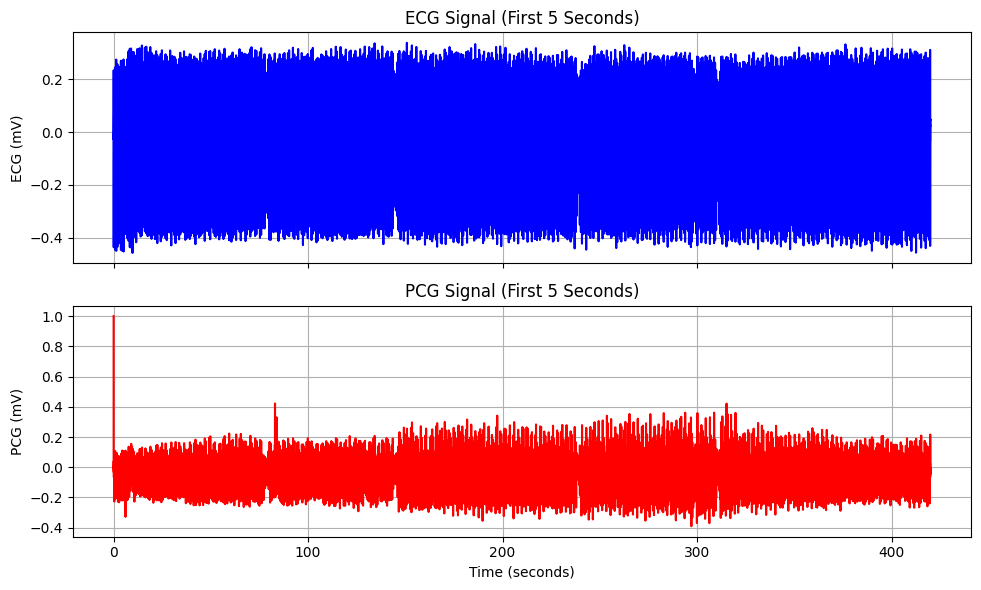

In [ ]:
#@title testing divided record
record = wfdb.rdrecord('/content/drive/MyDrive/ML Project Dataset/Divided Dataset/record_segment_1')

fs = record.fs  # Sampling frequency
duration = 420
num_samples = int(duration * fs)

ecg_signal = record.p_signal[:num_samples, 0]
pcg_signal = record.p_signal[:num_samples, 1]
time = np.linspace(0, duration, num_samples)

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot ECG
ax[0].plot(time, ecg_signal, color='b')
ax[0].set_title("ECG Signal (First 5 Seconds)")
ax[0].set_ylabel("ECG (mV)")
ax[0].grid()

# Plot PCG
ax[1].plot(time, pcg_signal, color='r')
ax[1].set_title("PCG Signal (First 5 Seconds)")
ax[1].set_xlabel("Time (seconds)")
ax[1].set_ylabel("PCG (mV)")
ax[1].grid()

plt.tight_layout()
plt.show()


## OLD

In [42]:
file_path = f'{records_path}/ECGPCG0001'
record = wfdb.rdheader(file_path)
# There's also wfdb.rdsamp() but idk how to make it work

In [40]:
print("Record Name:", record.record_name)
print("Number of Signals:", record.n_sig)
print("Sampling Frequency (Hz):", record.fs)
print("Signal Names:", record.sig_name)
print("Signal Units:", record.units)
print("Comments:", record.comments)
print("?", record.p_signal)

print(dir(record))
# Comments don't include the label (walking, sitting, etc.) IT'S IN THE CSV 'ECGPCGSpreadsheet.csv'

Record Name: ECGPCG0001
Number of Signals: 2
Sampling Frequency (Hz): 8000
Signal Names: ['ECG', 'PCG']
Signal Units: ['mV', 'mV']
Comments: ['The simultaneous electrocardiogram and phonocardiogram database']
? None
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_adjust_datetime', '_arrange_fields', '_auto_signal_file_names', 'adc', 'adc_gain', 'adc_res', 'adc_zero', 'base_counter', 'base_date', 'base_datetime', 'base_time', 'baseline', 'block_size', 'byte_offset', 'calc_adc_gain_baseline', 'calc_adc_params', 'calc_checksum', 'check_field', 'check_field_cohesion', 'check_read_inputs', 'check_sig_cohesion', 'checksum', 'comments', 'convert_dtype', 'counter_freq', 'd_signal', 'd

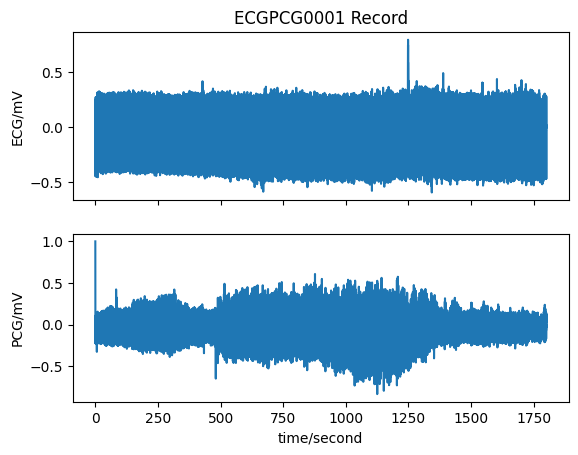

In [ ]:
record = wfdb.rdrecord(file_path)
wfdb.plot_wfdb(record=record, title='ECGPCG0001 Record')

# Record is 30 mins so it's difficult to visualize in one static plot


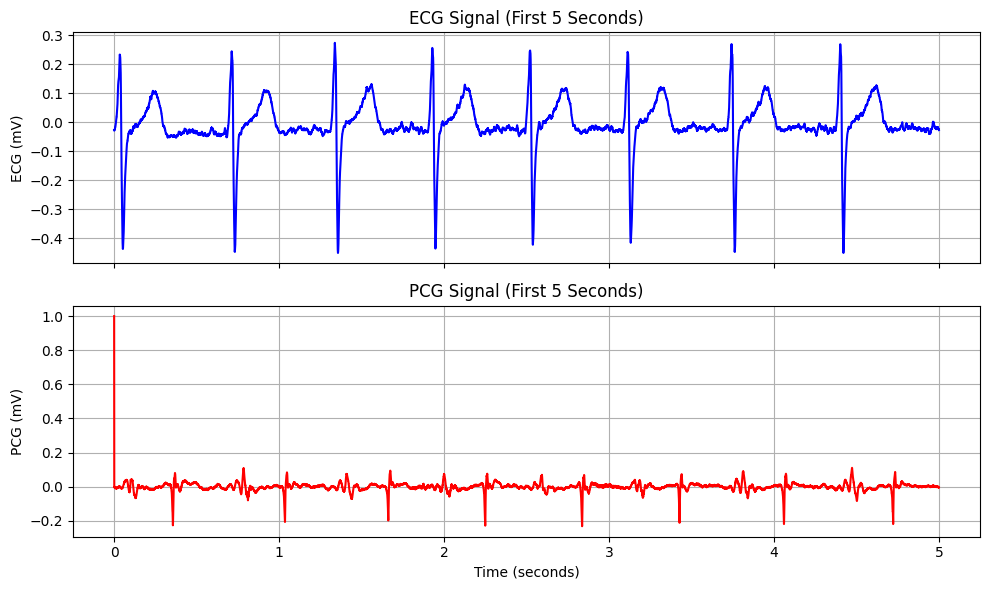

In [ ]:
record = wfdb.rdrecord(file_path)

fs = record.fs  # Sampling frequency
duration = 5
num_samples = int(duration * fs)

ecg_signal = record.p_signal[:num_samples, 0]
pcg_signal = record.p_signal[:num_samples, 1]
time = np.linspace(0, duration, num_samples)

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot ECG
ax[0].plot(time, ecg_signal, color='b')
ax[0].set_title("ECG Signal (First 5 Seconds)")
ax[0].set_ylabel("ECG (mV)")
ax[0].grid()

# Plot PCG
ax[1].plot(time, pcg_signal, color='r')
ax[1].set_title("PCG Signal (First 5 Seconds)")
ax[1].set_xlabel("Time (seconds)")
ax[1].set_ylabel("PCG (mV)")
ax[1].grid()

plt.tight_layout()
plt.show()


In [ ]:
#@title EXAMPLE FEATURE EXTRACTION
record = wfdb.rdrecord('Dataset/ECGPCG0001')
fs = record.fs
duration = 10
num_samples = int(duration * fs)

pcg_signal = record.p_signal[:num_samples, 1]  # Extract PCG
time = np.linspace(0, duration, num_samples)

def detect_s1_s2_intervals(signal, fs):
    """Detect peaks (heart sounds) and compute variability."""
    peaks, _ = find_peaks(signal, height=np.mean(signal))
    intervals = np.diff(peaks) / fs  # Convert to time
    return {
        "S1-S2 Variability": np.std(intervals),
        "Heart Rate": 60 / np.mean(intervals) if len(intervals) > 0 else np.nan
    }

def s1_s2_energy_ratio(signal):
    """Compute S1/S2 energy ratio using basic power analysis."""
    s1_energy = np.sum(signal[:len(signal)//2]**2)
    s2_energy = np.sum(signal[len(signal)//2:]**2)
    return {"S1/S2 Energy Ratio": s1_energy / (s2_energy + 1e-10)}

def spectral_entropy(signal, fs):
    """Compute Spectral Entropy from FFT."""
    f, Pxx = welch(signal, fs=fs, nperseg=min(1024, len(signal)))
    Pxx_norm = Pxx / np.sum(Pxx)  # Normalize power
    entropy = -np.sum(Pxx_norm * np.log(Pxx_norm + 1e-10))  # Shannon Entropy
    return {"Spectral Entropy": entropy}

def low_frequency_power(signal, fs, low_freq=0, high_freq=50):
    """Compute power in low-frequency band (0-50 Hz)."""
    f, Pxx = welch(signal, fs=fs, nperseg=min(1024, len(signal)))
    low_power = np.sum(Pxx[(f >= low_freq) & (f <= high_freq)])
    return {"Power in Low-Frequency Band": low_power}

s1_s2_features = detect_s1_s2_intervals(pcg_signal, fs)
energy_ratio = s1_s2_energy_ratio(pcg_signal)
entropy_feat = spectral_entropy(pcg_signal, fs)
low_freq_power = low_frequency_power(pcg_signal, fs)

all_features = {**s1_s2_features, **energy_ratio, **entropy_feat, **low_freq_power}

print("Extracted Features from PCG Signal (First 10s):")
for key, value in all_features.items():
    print(f"{key}: {value:.4f}")
